In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'#Supress debug info. We don't have a GPU or TPU, and if TensorFlow doesn't 
                                        #find one, it gets upset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import tensorflow as tf
import warnings
import tqdm
import sklearn
import math

from tqdm.keras import TqdmCallback
from sklearn import preprocessing
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, RationalQuadratic
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import qmc

In [11]:
plt.rcParams.update({
"text.usetex": True,
"font.family": "serif"
})
plt.style.use({'figure.facecolor':'white'})

path = os.path.abspath("")
up_one = os.path.normpath(os.path.dirname(path))
thesisFiguresPath = os.path.join(up_one, "figures", "thesis")
fileType = ".pdf"

def saveThesisFig(figName):
    figPath = os.path.join(thesisFiguresPath, figName+fileType)
    plt.savefig(figPath)

# Benchmark Functions from Guo et al.
Guo, M., Manzoni, A, Amendt, M., Conti, P., Hesthaven, J.S., "Multi-fidelity regression using artificial neural networks: efficient approximation of parameter-dependent
output quantities," [arXiv:2102.13403](https://arxiv.org/abs/2102.13403), 2021.

## Benchmark 1: High Fidelity Function
$$ y_{hf} = (6x-2)^2sin(12x-4) $$

## Benchmark 1: Low Fidelity Function
$$ y_{lf} = 0.5y_{hf} + 10(x-0.5) + 5 $$

In [3]:
## Benchmark Functions 1
def hf_function_bench1(x):
    y_hf1 = ((6*x - 2)**2)*np.sin(12*x-4)
    return y_hf1

def lf_function_bench1(x):
    y_lf1 = .5*hf_function_bench1(x) + 10*(x-0.5) + 5
    return y_lf1

## Functions For Building and Training the Models

In [55]:
#Building the model
def build_model_single_fidelity(input_data, output_data, ref_size, rate, reg):
    """

    :param input_data: input parameters/features
    :param output_data: outputs the NN is fitting
    :param ref_size: reference size for building the NN model
    :param rate: learning rate
    :param reg: L2 regularization value to drop weights
    :return:
    """
    inputlayershape = int(len(input_data[0,:]))
    outputlayershape = int(len(output_data[0,:]))

    layer1_size = ref_size
    layer2_size = ref_size
    layer3_size = ref_size
    inputs = tf.keras.Input(shape=(inputlayershape,))
    
    x = tf.keras.layers.Dense(layer1_size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(inputs)
    
    x = tf.keras.layers.Dense(layer2_size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(x)
    
#     x = tf.keras.layers.Dense(layer3_size,activation=tf.nn.tanh,
#                 kernel_regularizer=keras.regularizers.l2(reg),
#                 kernel_initializer = tf.keras.initializers.GlorotUniform()
#                 )(x)
    
    outputs = tf.keras.layers.Dense(outputlayershape, activation=tf.nn.leaky_relu,
                      kernel_regularizer= keras.regularizers.l2(reg),
                      kernel_initializer = tf.keras.initializers.GlorotUniform())(x)
    
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=rate),
             loss = "mse",
             metrics = [tf.keras.metrics.MeanSquaredError(),
                       tf.keras.metrics.RootMeanSquaredError(),])
                       # "mae"])
    tf.keras.utils.plot_model(model,show_shapes=True)
    return model

#Building the model
def build_model_multi_fidelity(input_data, output_data, ref_size, rate, reg):
    """

    :param input_data: input parameters/features
    :param output_data: outputs the NN is fitting
    :param ref_size: reference size for building the NN model
    :param rate: learning rate
    :param reg: L2 regularization value to drop weights
    :return:
    """
    inputlayershape = int(len(input_data[0,:]))
    outputlayershape = int(len(output_data[0,:]))

    layer1_size = ref_size
#     layer2_size = ref_size
#     layer3_size = ref_size
    inputs = tf.keras.Input(shape=(inputlayershape,))
    
    x = tf.keras.layers.Dense(layer1_size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(inputs)
    
    # Repeat the "x = ...(x) " pattern to generate more layers if desired   
    
    outputs = tf.keras.layers.Dense(outputlayershape, activation=tf.nn.leaky_relu,
                      kernel_regularizer= keras.regularizers.l2(reg),
                      kernel_initializer = tf.keras.initializers.GlorotUniform())(x)
    
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=rate),
             loss = "mse",
             metrics = [tf.keras.metrics.MeanSquaredError(),
                       tf.keras.metrics.RootMeanSquaredError(),
                       "mae"])
    tf.keras.utils.plot_model(model,show_shapes=True)
    return model

#training the model 

# tqdm_callback = tfa.callbacks.TQDMProgressBar()

def train_model_all_fidelity(model, input_data, output_data, numEpochs, myBatchSize, validSplit):
    callbacks_list = [
        keras.callbacks.EarlyStopping(
        monitor = "root_mean_squared_error",mode="min",
        patience=500, verbose=2),
        TqdmCallback(verbose=1)
#         keras.callbacks.ModelCheckpoint(
#         filepath=checkpoint_path.keras,
#         monitor="mean_squared_error")
#         keras.callbacks.LearningRateScheduler(scheduler
#         )
    ]
    
    history = model.fit(x=input_data,
                       y=output_data,
                       batch_size=myBatchSize,
                       epochs=numEpochs,
                       callbacks = callbacks_list,
                       verbose=False,
                       shuffle=False,
                       validation_split=validSplit,
                       use_multiprocessing=True)
    epochs = history.epoch
    return epochs, history.history

## Uniform Sampling
In the referenced paper, the authors used uniform sampling instead of a DOE sampling method like LHS. I will compare the results for both methods. 

In [4]:
## Uniform Sampling 
xt_LF_uni_bench1 = np.linspace(0, 1, num=32, endpoint=True).reshape(-1, 1)
xt_HF_uni_bench1 = np.linspace(0, 1, num=8, endpoint=True).reshape(-1, 1)

## Continuous Sampling, used for plotting true function 
x = np.linspace(0, 1, num=101, endpoint=True).reshape(-1,1)

# Training Data

## Generating Training Data

In this section, we're taking our sampling "x" points and generating "y" function results using the benchmark functions from the first section of this notebook. 

In [5]:
# yt == training outputs 
# hf , lf == high fidelity, low fidelity
# uni == uniform sampling 
# bench1 == benchmark function 1 from Guo paper

#BENCHMARK FUNCTION 1, low and high fideltiy training data, LHS and Uniform sampling
yt_hf1_uni = hf_function_bench1(xt_HF_uni_bench1)
yt_lf1_uni = lf_function_bench1(xt_LF_uni_bench1)

# Kriging, or Gaussian Process Models

## sklearn Gaussian Process

*Building our multi-fidelity kriging the ol' fashioned way* 

This way provides the user control over the hyperparameters (specifically the kernels, n restarts optimizer)

kernel: class-kernel instance, default=None
The kernel specifying the covariance function of the GP. If None is passed, the kernel ConstantKernel(1.0, constant_value_bounds="fixed" * RBF(1.0, length_scale_bounds="fixed") is used as default. Note that the kernel hyperparameters are optimized during fitting unless the bounds are marked as “fixed”.

n_restarts_optimizer: class-int, default=0
The number of restarts of the optimizer for finding the kernel’s parameters which maximize the log-marginal likelihood. The first run of the optimizer is performed from the kernel’s initial parameters, the remaining ones (if any) from thetas sampled log-uniform randomly from the space of allowed theta-values. If greater than 0, all bounds must be finite. Note that n_restarts_optimizer == 0 implies that one run is performed.

### Data Scaling

In order to model effectively, we'll want to scale our training data appropriately. In this case, we're using sklearn's ```preprocessing.StandardScaler()```. The module standardizes features by removing the mean and scaling to unit variance. The standard score of a sample x is calculated as: ```z = (x - u) / s```, where ```u``` is the mean of the training samples or zero if ```with_mean=False```, and ```s``` is the standard deviation of the training samples or one if ```with_std=False```.

This is included in the comments of the below code block, but keep in my that each data set needs its own distinct scaler object. If you don't create a scaler object for each data set, you won't be able to inverse transform the data properly. 

In [15]:
# Creating a variable that points to the preprocessing.StandardScaler() module. Each dataset needs its own
# scaler object for the inverse transformation. Otherwise, we'll be "inverse transforming" data set "x" using
# the scaling operations for data set "y."


lfScalerUni1 = None
hfScalerUni1 = None
lfScalerUni1 = preprocessing.StandardScaler()
hfScalerUni1 = preprocessing.StandardScaler()

In [16]:
# Using the scaler objects that we've created

yt_lf1_uni_scaled = lfScalerUni1.fit_transform(yt_lf1_uni)
yt_hf1_uni_scaled = hfScalerUni1.fit_transform(yt_hf1_uni)

#### Visual representation of the scaling of our training data. 
Top curve is actual data, bottom curve is scaled 

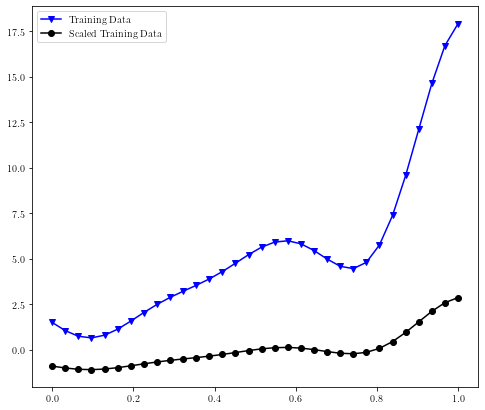

In [25]:
# #Training Data
plt.plot(xt_LF_uni_bench1,yt_lf1_uni,color="b",marker='v',label="LF Training Data")
# #Training Data
plt.plot(xt_LF_uni_bench1,yt_lf1_uni_scaled,color="k",marker = 'o',label="Scaled LF Training Data")
#Reference Function
# plt.plot(x,lf_function_bench1(x), color="k",label="True HF Function")
plt.legend()

### Kernels

#### What kernels do/how to select kernels: 
https://www.cs.toronto.edu/~duvenaud/cookbook/

In [17]:
# Kernel options include: Compound, Constant, Dot Product, Exponentiation, ExpSineSquared, 
# Product, Rational Quadratic, RBF, Sum, White

# Benchmark Function 1
kernel1 = ConstantKernel(1.0, (1e-8, 1e2)) * RBF(1.0, (1e-8, 1e2)) # Works great for Benchmark Function 1

### Fitting the Data and Inverse Transforming

In [18]:
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
# Low Fidelity Model
krig_lf_uni1 = None
krig_lf_uni1 = gaussian_process.GaussianProcessRegressor(kernel=kernel1,n_restarts_optimizer=20)
krig_lf_uni1.fit(xt_LF_uni_bench1, yt_lf1_uni_scaled)
krig_lf_uni1_predict_output = krig_lf_uni1.predict(x)
krig_lf_uni1_predict_output = lfScalerUni1.inverse_transform(krig_lf_uni1_predict_output)


 
# Multi Fidelity Models 
krig_mf_uni1 = None
krig_mf_uni1 = gaussian_process.GaussianProcessRegressor(kernel=kernel1,n_restarts_optimizer=20)
in_mf_uni1 = xt_HF_uni_bench1
ylf_uni1_in = krig_lf_uni1.predict(in_mf_uni1)
in_mf_uni1 = np.concatenate((in_mf_uni1,ylf_uni1_in),axis=1)
krig_mf_uni1.fit(in_mf_uni1, yt_hf1_uni_scaled)
ylf_uni1_in2 = krig_lf_uni1.predict(x)
in_mf2_uni1 = np.concatenate((x,ylf_uni1_in2),axis=1)
krig_mf_uni1_predict = krig_mf_uni1.predict(in_mf2_uni1)
krig_mf_uni1_predict = hfScalerUni1.inverse_transform(krig_mf_uni1_predict)


c:\Users\tyler\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


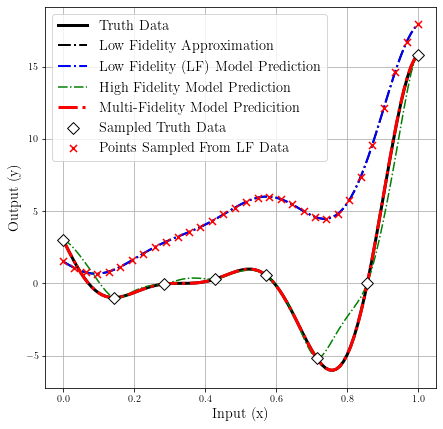

In [20]:
kernel1 = ConstantKernel(1.0, (1e-10, 1e5)) * RBF(1.0, (1e-10, 1e5)) + WhiteKernel()
# kernel1 = ConstantKernel(1.0, (1e-8, 1e5)) * Matern() + WhiteKernel() + RationalQuadratic()
kernel = 1.0*Matern(length_scale=0.1, nu=1.5)

# High Fidelity Models
krig_hf_uni1 = None
krig_hf_uni1 = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=20)
krig_hf_uni1.fit(xt_HF_uni_bench1, yt_hf1_uni_scaled)
krig_hf_uni1_predict_output = krig_hf_uni1.predict(x)
krig_hf_uni1_predict_output = hfScalerUni1.inverse_transform(krig_hf_uni1_predict_output)

# gp_hf = None
# gp_hf = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
# gp_hf.fit(xhf, scaler_gp_yhf.fit_transform(yhf))
# yhf_gp, yhf_gp_std = gp_hf.predict(xi, return_std=True)
# yhf_gp = scaler_gp_yhf.inverse_transform(yhf_gp)
# yhf_gp_std = yhf_gp_std.reshape(-1,1)
# yhf_gp_std = scaler_gp_yhf.inverse_transform(yhf_gp_std)



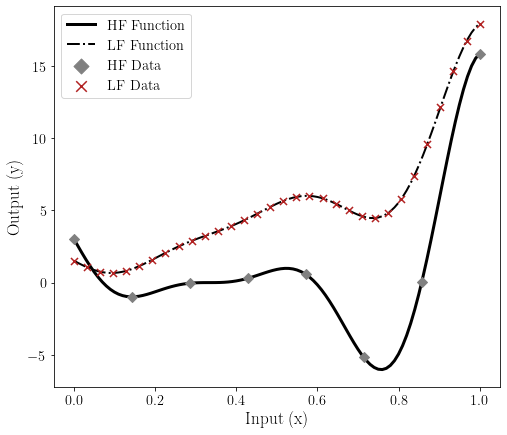

In [38]:
plt.rcParams["figure.figsize"] = (8,7)
ticksize='x-large'

plt.plot(x,hf_function_bench1(x), label="HF Function",linestyle="-", color="k", linewidth=3)
plt.plot(x,lf_function_bench1(x), label="LF Function",linestyle="-.", color="k", linewidth=2)

plt.xlabel('Input (x)', fontsize='xx-large')
plt.ylabel('Output (y)', fontsize='xx-large')
plt.scatter(xt_HF_uni_bench1, yt_hf1_uni, marker="D",s=50, color="grey", label = "HF Data",zorder=3)
plt.scatter(xt_LF_uni_bench1, yt_lf1_uni, marker="x",s=50,color="firebrick", label = "LF Data",zorder=3)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

plt.legend(loc=0, fontsize='x-large',markerscale = 1.5)

figName = '1D_samplingPlan'
saveThesisFig(figName)

### Plotting Our Models

Text(0, 0.5, 'Output (y)')

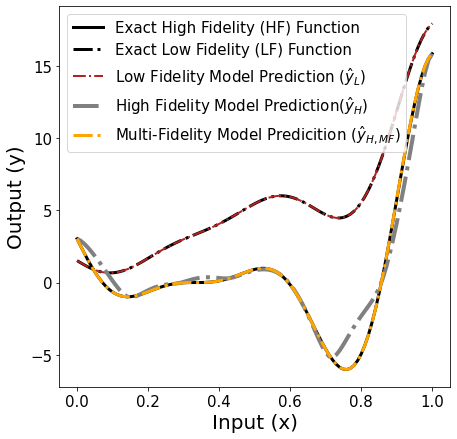

In [159]:
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams['font.size'] = 15

#Build 1
plt.plot(x,hf_function_bench1(x), label="Exact High Fidelity (HF) Function",linestyle="-", color="k", linewidth=3)
plt.plot(x,lf_function_bench1(x), label="Exact Low Fidelity (LF) Function",linestyle="-.", color="k", linewidth=3)

#Build 2
# plt.scatter(xt_HF_uni_bench1, yt_hf1_uni, marker="D",s=50, color="grey", label = "Points Sampled From HF Data ($y_H$)",zorder=3)
# plt.scatter(xt_LF_uni_bench1, yt_lf1_uni, marker="o",s=50,color="firebrick", label = "Points Sampled From LF Data ($y_L$)",zorder=3)

# #Build 3
# plt.plot(x,krig_lf_uni1_predict_output, label="Low Fidelity Model Prediction ($\hat{y}_L$)",linestyle="-.", color="firebrick", linewidth=2)
# plt.plot(x,krig_hf_uni1_predict_output, label="High Fidelity Model Prediction($\hat{y}_H$)",linestyle="-.", color="grey", zorder=3, linewidth = 4)

#Build 4
plt.plot(x,krig_lf_uni1_predict_output, label="Low Fidelity Model Prediction ($\hat{y}_L$)",linestyle="-.", color="firebrick", linewidth=2)
plt.plot(x,krig_hf_uni1_predict_output, label="High Fidelity Model Prediction($\hat{y}_H$)",linestyle="-.", color="grey", zorder=3, linewidth = 4)
plt.plot(x,krig_mf_uni1_predict, label="Multi-Fidelity Model Predicition ($\hat{y}_{H,MF}$)",linestyle="-.", color="orange", linewidth=3,zorder = 4)

plt.legend(loc=0,markerscale = 2)
plt.xlabel('Input (x)', fontsize=20)
plt.ylabel('Output (y)',fontsize=20)

# Neural Networks

Now, we'll build the multi-fidelity Neural Network

## Callbacks Documentation:

#### EarlyStopping: https://keras.io/api/callbacks/early_stopping/
Stops when the model stops improving. Helps to prevent overfitting, speeds up training
#### ModelCheckpoint: https://keras.io/api/callbacks/model_checkpoint/
Saves the most recent "good" model
#### Reduce Learning Rate on Plateau: https://keras.io/api/callbacks/reduce_lr_on_plateau/
Attempts to "kick" the model out of a plateau if it gets stuck. 
#### tqdm
Progress bar instead of neverending scroll of epochs

In [48]:
# names = ['xt_LF_uni_bench1',
#             'xt_HF_uni_bench1',
#             'xt_LF_lhs_bench1',
#             'xt_HF_lhs_bench1',
#             'xt_LF_uni_bench2',
#             'xt_HF_uni_bench2',
#             'xt_LF_lhs_bench2',
#             'xt_HF_lhs_bench2',
#             'xt_LF_uni_bench3',
#             'xt_HF_uni_bench3',
#             'xt_LF_lhs_bench3',
#             'xt_HF_lhs_bench3']
# xt_list = [xt_LF_uni_bench1, 
#            xt_HF_uni_bench1,
#            xt_LF_lhs_bench1,
#            xt_HF_lhs_bench1,
#            xt_LF_uni_bench2, 
#            xt_HF_uni_bench2,
#            xt_LF_lhs_bench2,
#            xt_HF_lhs_bench2,
#            xt_LF_uni_bench3, 
#            xt_HF_uni_bench3,
#            xt_LF_lhs_bench3,
#            xt_HF_lhs_bench3]

# xt_dict = dict(zip(names,xt_list))


## Hyperparameters

In [31]:
#Initialize hyperparamters for Single Fidelity Model

# ref_size = 64 #this is whats used in the paper 
ref_size = 100 #used by Dr. Reasor
rate = 4.0e-3 #From Deep Learning w/ Python (Chollet)
# rate = 5.0e-2 # used by Dr. Reasor
reg = 1.0e-6
numEpochs = 10000
myBatchSize = None
validSplit = None

## Data Scaling 

Only required to run this block if you haven't already run the Kriging model. It's the same code. 

In [24]:
# You'll only need to run this if you haven't already run the Kriging model 

# Creating a variable that points to the preprocessing.StandardScaler() module. Each dataset needs its own
# scaler object for the inverse transformation. Otherwise, we'll be "inverse transforming" data set "x" using
# the scaling operations for data set "y."

lfScalerUni1 = None
hfScalerUni1 = None
lfScalerUni1 = preprocessing.StandardScaler()
hfScalerUni1 = preprocessing.StandardScaler()

In [25]:
# Using the scaler objects that we've created


yt_lf1_uni_scaled = lfScalerUni1.fit_transform(yt_lf1_uni)
yt_hf1_uni_scaled = hfScalerUni1.fit_transform(yt_hf1_uni)

## Build the Single Fidelity Models

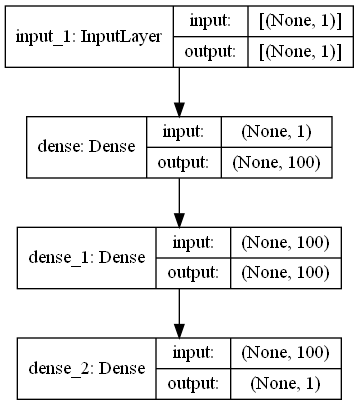

In [26]:
# It's best practice to clear any old model data out every time that you retrain the model. Some parameters from
# previous runs may be left over, and you may end up with a weird/ill-fitting model

modelnames = [
    'NN_lf_uni1',
    'NN_hf_uni1',
]
for name in modelnames:
    locals()[name] = None
    
#############

###### LOW FIDELITY ########
NN_lf_uni1 = build_model_single_fidelity(xt_LF_uni_bench1, yt_lf1_uni_scaled, ref_size, rate, reg)

###### HIGH FIDELITY ########
NN_hf_uni1 = build_model_single_fidelity(xt_HF_uni_bench1, yt_hf1_uni_scaled, ref_size, rate, reg)

##Check to see if your model is built correctly, feel free to use any of the above models to test the 
## functionality. This function becomes much more useful when we have more than one input or output, or 
## multi-dimensional input and output
tf.keras.utils.plot_model(NN_lf_uni1,show_shapes=True)

## Train the Single Fidelity Models

In [32]:
#Train the Model 

# LFepochs, LFhistory = train_model_all_fidelity(LFmodel, input_data, output_data, numEpochs, myBatchSize, validSplit)

#Benchmark function 1, low fidelity
LFEpochs_uni1, LFHistory_uni1 = train_model_all_fidelity(
    NN_lf_uni1,xt_LF_uni_bench1, yt_lf1_uni_scaled,numEpochs, myBatchSize, validSplit)

##########################################################################################

#Benchmark function 1, high fidelity
HFEpochs_uni1, HFHistory_uni1 = train_model_all_fidelity(
    NN_hf_uni1,xt_HF_uni_bench1, yt_hf1_uni_scaled,numEpochs, myBatchSize, validSplit)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 02679: early stopping


## Analyze Error (MSE) In Single Fidelity Models

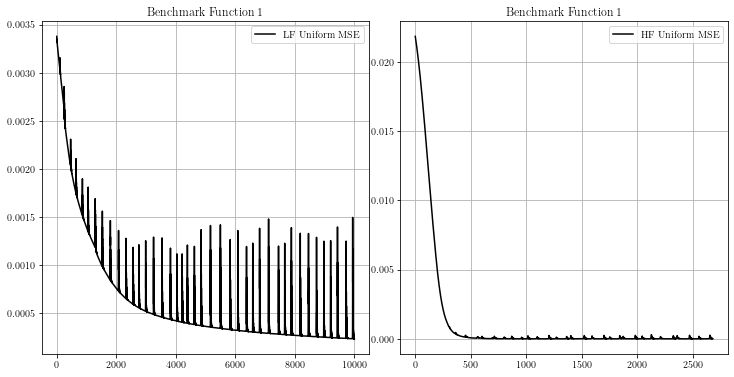

In [33]:
###### Low Fidelity Mean Squared Error
mse_history_lfUni1 = LFHistory_uni1["mean_squared_error"]
mse_history_hfUni1 = HFHistory_uni1["mean_squared_error"]

plt.rcParams["figure.figsize"] = (10,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#Low Fidelity NN MSE, Benchmark 1
axs[0].plot(range(1,len(mse_history_lfUni1[:]) + 1),mse_history_lfUni1[:],
              label="LF Uniform MSE",linestyle="-", color="k")
axs[0].set_title("Benchmark Function 1")
axs[0].legend(loc=0)
axs[0].grid()
################################################################

# High Fidelity NN MSE, Benchmark 1
axs[1].plot(range(1,len(mse_history_hfUni1[:]) + 1),mse_history_hfUni1[:],
              label="HF Uniform MSE",linestyle="-", color="k")
axs[1].set_title("Benchmark Function 1")
axs[1].legend(loc=0)
axs[1].grid()

## Generate Predictions

In [34]:
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

y_lf_nn_uni1 = NN_lf_uni1.predict(x)
y_hf_nn_uni1 = NN_hf_uni1.predict(x)

y_lf_nn_uni1 = lfScalerUni1.inverse_transform(y_lf_nn_uni1)
y_hf_nn_uni1 = hfScalerUni1.inverse_transform(y_hf_nn_uni1)

## Multi-Fidelity Neural Networks

In [42]:
## Now, to make our Multi-Fidelity Neural Network 
# input_data = xt_HF_uni_bench1_mod
# output_data = yt_hf1_uni_mod

# yt_LF_in = LFmodel.predict(xt_HF_uni_bench1_mod)
# These y values are already scaled 
yt_lf_uni1_in = NN_lf_uni1.predict(xt_HF_uni_bench1)

# mf_input_data = np.concatenate((xt_HF_uni_bench1_mod,yt_LF_in), axis=1)
mf_uni1_input_data = np.concatenate((xt_HF_uni_bench1,yt_lf_uni1_in), axis = 1)

# Multi-Fidelity Output Data = hf_BenchmarkFunction(High Fidelity Training Inputs, "x")
mf_uni1_output_data = yt_hf1_uni_scaled

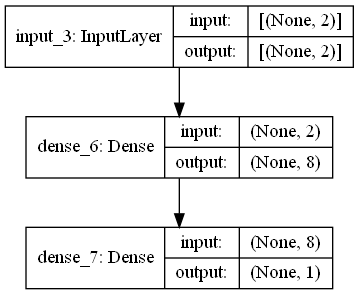

In [43]:
#Initialize hyperparamters for Multi Fidelity Model
# ref_size = 34 #this is whats used in the paper 
ref_size_uni1 = int(len(mf_uni1_input_data))

# The below hyperparameters remain unchanged
# rate = 5.17e-2 #Learning rate
# reg = 1.01e-4
# numEpochs = 10000
# myBatchSize = None
# validSplit = None

#Clearing old models, if there are any 
modelnames = [
    'NN_mf_uni1',
]
for name in modelnames:
    locals()[name] = None

##Build the model, show the graph
# MFmodel = build_model_multi_fidelity(mf_input_data, mf_output_data, ref_size, rate, reg)
NN_mf_uni1 = build_model_multi_fidelity(mf_uni1_input_data, mf_uni1_output_data, ref_size_uni1, rate, reg)

tf.keras.utils.plot_model(NN_mf_uni1,show_shapes=True)

In [56]:
#Train the model 

modelnames = [
    'NN_mf_uni1_epochs',
    'NN_mf_uni1_history',
]
for name in modelnames:
    locals()[name] = None
numEpochs = 15000
    
# MFepochs, MFhistory = train_model_all_fidelity(MFmodel, mf_input_data, mf_output_data, numEpochs, myBatchSize, validSplit)
NN_mf_uni1_epochs, NN_mf_uni1_history = train_model_all_fidelity(NN_mf_uni1, mf_uni1_input_data, mf_uni1_output_data, 
                                                                 numEpochs, myBatchSize, validSplit)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00540: early stopping


In [57]:
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
# mf_predict_input = np.concatenate((x,y_lf_nn),axis=1)
# y_lf_nn_uni1
y_lf_nn_uni1 = NN_lf_uni1.predict(x)



mf_predict_input_uni1 = np.concatenate((x,y_lf_nn_uni1),axis=1)

# y_mf_nn = MFmodel.predict(mf_predict_input)
y_mf_nn_uni1_predicted = NN_mf_uni1.predict(mf_predict_input_uni1)

y_mf_nn_uni1_predicted = hfScalerUni1.inverse_transform(y_mf_nn_uni1_predicted)
y_lf_nn_uni1 = lfScalerUni1.inverse_transform(y_lf_nn_uni1)

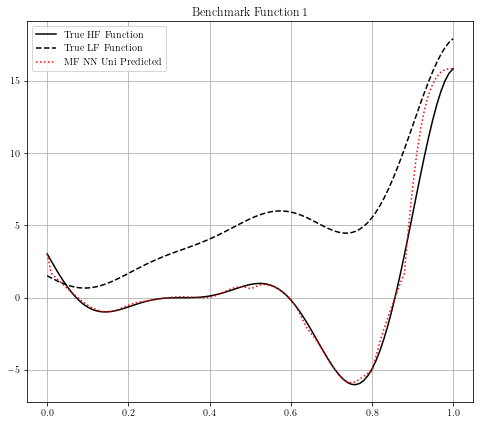

In [58]:
#Reference Functions, Benchmark 1
plt.plot(x,hf_function_bench1(x), label="True HF Function",linestyle="-", color="k")
plt.plot(x,lf_function_bench1(x), label="True LF Function",linestyle="--", color="k")
#Predicted Values 
plt.plot(x,y_mf_nn_uni1_predicted, label="MF NN Uni Predicted",linestyle=":", color="r")
plt.title("Benchmark Function 1")
plt.legend(loc=0)
plt.grid()

## Analyze MSE in MF Neural Networks

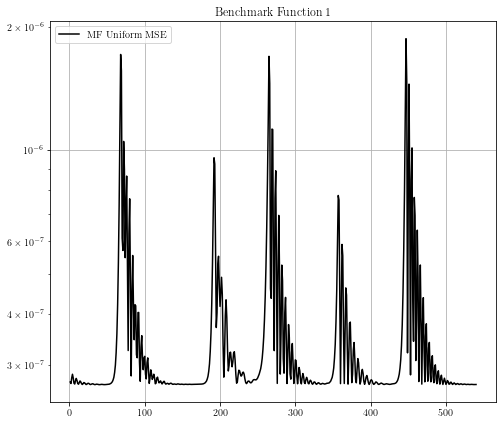

In [59]:
NN_mf_uni1_epochs, NN_mf_uni1_history 

###### Low Fidelity Mean Squared Error
mse_history_mfUni1 = NN_mf_uni1_history["mean_squared_error"]

# plt.plot(range(1,len(mse_history[1000:]) + 1),mse_history[1000:])
# plt.xlabel("Epochs")
# plt.ylabel("Mean Squared Error")
# plt.show()

#Low Fidelity NN MSE, Benchmark 1
plt.semilogy(range(1,len(mse_history_mfUni1[:]) + 1),mse_history_mfUni1[:],
              label="MF Uniform MSE",linestyle="-", color="k")
plt.title("Benchmark Function 1")
plt.legend(loc=0)
plt.grid()

# Plot Generated Predictions

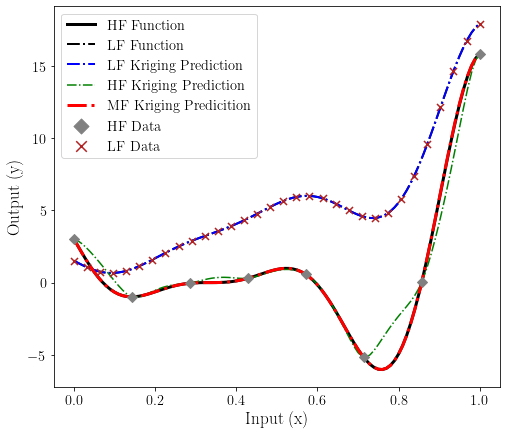

In [41]:
plt.rcParams["figure.figsize"] = (8,7)
ticksize='x-large'

plt.plot(x,hf_function_bench1(x), label="HF Function",linestyle="-", color="k", linewidth=3)
plt.plot(x,lf_function_bench1(x), label="LF Function",linestyle="-.", color="k", linewidth=2)

plt.xlabel('Input (x)', fontsize='xx-large')
plt.ylabel('Output (y)', fontsize='xx-large')
plt.scatter(xt_HF_uni_bench1, yt_hf1_uni, marker="D",s=50, color="grey", label = "HF Data",zorder=3)
plt.scatter(xt_LF_uni_bench1, yt_lf1_uni, marker="x",s=50,color="firebrick", label = "LF Data",zorder=3)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

#Reference Functions, Benchmark 1
#Predicted Values 
plt.plot(x,krig_lf_uni1_predict_output, label="LF Kriging Prediction",linestyle="-.", color="blue", linewidth=2)
plt.plot(x,krig_hf_uni1_predict_output, label="HF Kriging Prediction",linestyle="-.", color="green")
plt.plot(x,krig_mf_uni1_predict, label="MF Kriging Predicition",linestyle="-.", color="red", linewidth=3)

plt.legend(loc=0, fontsize='x-large',markerscale = 1.5)

figName = '1D_kriging'
saveThesisFig(figName)

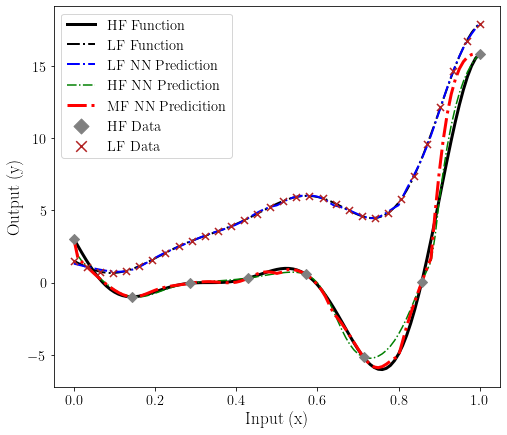

In [60]:
# #Predicted Values 
# plt.plot(x,y_lf_nn_uni1, label="LF NN Predicted",linestyle="-.", color="b")
# plt.plot(x,y_hf_nn_uni1, label="HF NN Predicted",linestyle="-.", color="b")

plt.rcParams["figure.figsize"] = (8,7)
ticksize='x-large'

plt.plot(x,hf_function_bench1(x), label="HF Function",linestyle="-", color="k", linewidth=3)
plt.plot(x,lf_function_bench1(x), label="LF Function",linestyle="-.", color="k", linewidth=2)

plt.xlabel('Input (x)', fontsize='xx-large')
plt.ylabel('Output (y)', fontsize='xx-large')
plt.scatter(xt_HF_uni_bench1, yt_hf1_uni, marker="D",s=50, color="grey", label = "HF Data",zorder=3)
plt.scatter(xt_LF_uni_bench1, yt_lf1_uni, marker="x",s=50,color="firebrick", label = "LF Data",zorder=3)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

#Reference Functions, Benchmark 1
#Predicted Values 
plt.plot(x,y_lf_nn_uni1, label="LF NN Prediction",linestyle="-.", color="blue", linewidth=2)
plt.plot(x,y_hf_nn_uni1, label="HF NN Prediction",linestyle="-.", color="green")
plt.plot(x,y_mf_nn_uni1_predicted, label="MF NN Predicition",linestyle="-.", color="red", linewidth=3)

plt.legend(loc=0, fontsize='x-large',markerscale = 1.5)

figName = '1D_NN'
saveThesisFig(figName)